# Preparations

##Install Necessary Packages

In [ ]:
# install  necessary packages
!pip install ipympl  pandas scikit-learn tensorflow colorama art



## Import Packages and Setup Constants

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from art import *
import sys
import os
from colorama import Fore, Style
import warnings

filepath = "insurance.csv"




# Text formatting
BOLD = Style.BRIGHT
END = Style.RESET_ALL

# Text colors
GREEN = Fore.GREEN
RED = Fore.RED
PURPLE = Fore.MAGENTA
YELLOW = Fore.YELLOW
BLUE = Fore.CYAN


# Pre-formatted strings
str_separator = f"\n{PURPLE}================================================{END}\n"
str_pressEnter = f"\n\n{BLUE}Press ENTER to continue...{END}"
str_choiceSelection = f"{BLUE}Enter your choice: {END}"


# Test dataset, not seen during training
test_dataset = [
    [25, 'male', 26.22, 0, 'no', 'northeast', 2721.3208],
    [64, 'female', 39.33, 0, 'no', 'northeast', 14901.5167],
    [30, 'female', 19.95, 3, 'no', 'northwest', 5693.4305],
    [57, 'female', 23.98, 1, 'no', 'southeast', 22192.43711],
    [31, 'male', 27.645, 2, 'no', 'northeast', 5031.26955],
    [22, 'male', 52.58, 1, 'yes', 'southeast', 44501.3982],
    [32, 'female', 41.1, 0, 'no', 'southwest', 3989.841],
    [33, 'male', 35.75, 1, 'yes', 'southeast', 38282.7495],
    [28, 'male', 31.68, 0, 'yes', 'southeast', 34672.1472],
    [43, 'female', 35.64, 1, 'no', 'southeast', 7345.7266],
    [49, 'male', 28.69, 3, 'no', 'northwest', 10264.4421],
    [41, 'male', 23.94, 1, 'no', 'northeast', 6858.4796],
    [30, 'male', 25.46, 0, 'no', 'northeast', 3645.0894],
    [48, 'female', 33.33, 0, 'no', 'southeast', 8283.6807],
    [35, 'female', 35.86, 2, 'no', 'southeast', 5836.5204],
    [56, 'female', 35.8, 1, 'no', 'southwest', 11674.13],
    [25, 'female', 32.23, 1, 'no', 'southeast', 18218.16139]
]

warnings.filterwarnings("ignore") #suppress warnings

# Models

## Base Model Class (for All Models)

In [ ]:
class BaseModel:
    def __init__(self, filepath):

        # Load dataset from provided filepath
        self.dataset = pd.read_csv(filepath)

        # Create a backup of the original dataset
        self.dataset_original = self.dataset.copy()

        # Initializing instance-level variables for data and data splits
        self.x = None
        self.y = None
        self.x_train = None
        self.x_cv = None
        self.x_test = None
        self.y_train = None
        self.y_cv = None
        self.y_test = None

        # Dictionaries to store StandardScaler and LabelEncoder objects
        self.scalers = {}
        self.encoders = {}

        # Start data preprocessing (encoding, splitting, scaling)
        self.preprocess_data()

    def preprocess_data(self):
        """  Main preprocessing function that encodes categorical features, splits the data, and scales the features. """
        self.encode_categorical()
        self.split_data()
        self.feature_scaling()

    def encode_categorical(self):
        """  Encodes categorical columns in the dataset using the LabelEncoder. """

        # Convert given columns to 'category' dtype
        self.dataset[['sex', 'smoker', 'region']] = self.dataset[['sex', 'smoker', 'region']].astype('category')

        # Loop through columns and encode them using LabelEncoder
        for col in ['sex', 'smoker', 'region']:
            label = LabelEncoder()

            # Store each encoder in the dictionary for potential use later
            self.encoders[col] = label
            self.dataset[col] = label.fit_transform(self.dataset[col])

    def split_data(self):
        """ Splits the data into training, cross-validation, and test sets using a 70-15-15 split. """
        # Separate features and target variable
        self.x = self.dataset.drop('charges', axis=1).values
        self.y = self.dataset['charges'].values
        # Split data into training and temporary sets (70-30 split)
        self.x_train, x_temp, self.y_train, y_temp = train_test_split(self.x, self.y, train_size=0.7, random_state=42)
        # Further split the temporary set into cross-validation and test sets (50-50 split)
        self.x_cv, self.x_test, self.y_cv, self.y_test = train_test_split(x_temp, y_temp, train_size=0.5, random_state=42)



    def feature_scaling(self):
        """ Applies feature scaling (standardization) on training, cross-validation, and test data.  """

        scaler = StandardScaler()

        # Store the scaler object for potential inverse scaling later
        self.scalers['x'] = scaler


        # Convert DataFrame slices to numpy arrays before scaling
        self.x_train = scaler.fit_transform(self.x_train.astype(float))  # Fit and transform training data
        self.x_cv = scaler.transform(self.x_cv.astype(float))
        self.x_test = scaler.transform(self.x_test.astype(float))

        # Transform (using training data mean and std dev) cross-validation and test data
        #self.x_train = scaler.fit_transform(self.x_train)  # Fit and transform training data
        #self.x_cv = scaler.transform(self.x_cv)
        #self.x_test = scaler.transform(self.x_test)

    def train(self):
        # Placeholder for the training method to be implemented by subclasses
        raise NotImplementedError("Train method not implemented")

    def predict(self, x):
        # Placeholder for the prediction method to be implemented by subclasses
        raise NotImplementedError("Predict method not implemented")

    def preprocess_new_data(self, x):
        """Preprocess new input data in the same way as the training data."""
        df = pd.DataFrame(x, columns=self.dataset_original.drop('charges', axis=1).columns)

        # Encode categorical columns
        for col, encoder in self.encoders.items():
            df[col] = encoder.transform(df[col])

        # Scale the features
        x_scaled = self.scalers['x'].transform(df)
        return x_scaled


    def inverse_transform(self, x, y):
        """
        Inverse transforms feature scaled and label encoded data.
        Helpful for visualization or further processing on original scale.
        """

        x = pd.DataFrame(self.scalers['x'].inverse_transform(x), columns=self.dataset_original.drop('charges', axis=1).columns)

        # Loop through encoded columns and inverse transform them
        for col, encoder in self.encoders.items():
            x[col] = encoder.inverse_transform(x[col].astype(int))
        return x, y

    def plot_features_vs_target(self):
        """
        Plots various features against the target variable to understand their relationship.
        """

        # Define subplots layout
        fig, axs = plt.subplots(2, 2, figsize=(10, 7))

        # Plot using the original (non-encoded, non-scaled) dataset
        sns.barplot(x='region', y='charges', hue='smoker', data=self.dataset_original, ax=axs[0, 0])
        axs[0, 0].set_title('Region vs Charges')
        sns.barplot(x='children', y='charges', hue='smoker', data=self.dataset_original, ax=axs[0, 1])
        axs[0, 1].set_title('Children vs Charges')
        sns.scatterplot(x='age', y='charges', hue='smoker', data=self.dataset_original, ax=axs[1, 0])
        axs[1, 0].set_title('Age vs Charges')
        sns.scatterplot(x='bmi', y='charges', hue='smoker', data=self.dataset_original, ax=axs[1, 1])
        axs[1, 1].set_title('BMI vs Charges')

        # Set main title for all plots
        fig.suptitle("Dataset Analysis", fontsize=16)
        plt.tight_layout()
        plt.show()

    def plot_dataset_split_distribution(self):
        """
        Plots the distribution of the dataset after splitting into training, cross-validation, and test sets.
        Aids in understanding the distribution of data across the splits.
        """

        # Inverse transform data splits for visualization
        df_X_train, df_y_train = self.inverse_transform(self.x_train, self.y_train)
        df_X_cv, df_y_cv = self.inverse_transform(self.x_cv, self.y_cv)
        df_X_test, df_y_test = self.inverse_transform(self.x_test, self.y_test)


        # Convert numpy arrays to DataFrames for easier plotting
        df_y_train = pd.DataFrame(df_y_train, columns=['charges'])
        df_y_cv = pd.DataFrame(df_y_cv, columns=['charges'])
        df_y_test = pd.DataFrame(df_y_test, columns=['charges'])

        # Concatenate features and target to form complete datasets for each split
        df_train = pd.concat([df_X_train, df_y_train], axis=1)
        df_cv = pd.concat([df_X_cv, df_y_cv], axis=1)
        df_test = pd.concat([df_X_test, df_y_test], axis=1)

        # Define subplots layout
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        sns.scatterplot(x='age', y='charges', data=df_train, ax=axes[0])
        axes[0].set_title('Age vs Charges (Train)')
        sns.scatterplot(x='age', y='charges', data=df_cv, ax=axes[1])
        axes[1].set_title('Age vs Charges (CV)')
        sns.scatterplot(x='age', y='charges', data=df_test, ax=axes[2])
        axes[2].set_title('Age vs Charges (Test)')

        fig.suptitle("Dataset Split Distribution", fontsize=16)
        plt.tight_layout()
        plt.show()


## Linear Regression Model Class

In [ ]:


class LinearModel(BaseModel):
    def __init__(self, filepath):
        """Initializing the base model and setting up the linear model."""

        super().__init__(filepath)
        self.model = None
        self.train()

    def train(self):
        """Trains the linear regression model"""
        self.model = LinearRegression()
        self.model.fit(self.x_train, self.y_train)


    def predict(self, x):
        """Predicts target values using the trained linear regression model"""

        if self.model is None:
            raise ValueError("Model has not been trained. Call the train method first.")

        x_preprocessed = self.preprocess_new_data(x)
        return self.model.predict(x_preprocessed)

    def print_results(self):
        """Prints the performance metrics of the model for CV and test sets."""

        # Predictions on test set
        y_pred_test = self.model.predict(self.x_test)
        test_score = r2_score(self.y_test, y_pred_test)

        # Predictions on CV set
        y_pred_cv = self.model.predict(self.x_cv)
        cv_score = r2_score(self.y_cv, y_pred_cv)

        # Print scores
        print(f"Linear Model Score (CV): {cv_score * 100:.2f}%")
        print(f"Linear Model Score (Test Set): {test_score * 100:.2f}%")


## Polynomial Regression Model Class

In [ ]:
class PolynomialRegressionModel(BaseModel):


    def __init__(self, filepath):
        """Initializing base model and setting hyperparameters."""

        super().__init__(filepath)

        self.alphas = [0.01, 0.1, 0.5, 1, 10, 100, 500, 1000]
        self.degrees = list(range(1, 5))

        #Lists to store errors and scores for different hyperparameters.
        self.train_errors_degree = []
        self.cv_errors_degree = []
        self.scores_degree = []

        self.train_errors_alpha = []
        self.cv_errors_alpha = []
        self.scores_alpha = []

        # Default values for best hyperparameters
        self.best_degree = 2
        self.best_alpha = 1
        self.best_model = None
        self.poly = None

        self.train()


    def train(self):
        """Training logic to find best hyperparameters and initialize best model."""

        self.find_best_degree()
        self.find_best_alpha_ridge()
        self.initialize_best_model()


    def initialize_best_model(self):
        """Initialize the best model based on best hyperparameters found."""

        self.poly = PolynomialFeatures(degree=self.best_degree)
        x_train_pol = self.poly.fit_transform(self.x_train)

        if self.best_alpha == 0:
            self.best_model = LinearRegression()
        else:
            self.best_model = Ridge(alpha=self.best_alpha)

        self.best_model.fit(x_train_pol, self.y_train)


    def find_best_degree(self):
        """Find the best polynomial degree for the model."""

        for degree in self.degrees:
            # Following the provided code for polynomial regression
            poly = PolynomialFeatures(degree=degree)
            x_train_pol = poly.fit_transform(self.x_train)
            x_cv_pol = poly.transform(self.x_cv)
            x_test_pol = poly.transform(self.x_test)

            poly_reg = LinearRegression()
            poly_reg.fit(x_train_pol, self.y_train)

            y_train_pred = poly_reg.predict(x_train_pol)
            y_cv_pred = poly_reg.predict(x_cv_pol)

            train_error = mean_squared_error(self.y_train, y_train_pred)
            cv_error = mean_squared_error(self.y_cv, y_cv_pred)

            y_test_pred = poly_reg.predict(x_test_pol)
            score = r2_score(self.y_test, y_test_pred)
            self.train_errors_degree.append(train_error)
            self.cv_errors_degree.append(cv_error)
            self.scores_degree.append(score)

        self.best_degree = np.argmin(self.cv_errors_degree) + 1

    def find_best_alpha_ridge(self):
        """Find the best alpha value for Ridge regularization."""

        poly = PolynomialFeatures(degree=self.best_degree)
        x_train_pol = poly.fit_transform(self.x_train)
        x_cv_pol = poly.transform(self.x_cv)
        x_test_pol = poly.transform(self.x_test)

        for alpha in self.alphas:
            ridge_reg = Ridge(alpha=alpha)
            ridge_reg.fit(x_train_pol, self.y_train)

            y_train_pred = ridge_reg.predict(x_train_pol)
            y_cv_pred = ridge_reg.predict(x_cv_pol)
            train_error = mean_squared_error(self.y_train, y_train_pred)
            cv_error = mean_squared_error(self.y_cv, y_cv_pred)
            score = ridge_reg.score(x_test_pol, self.y_test)

            self.train_errors_alpha.append(train_error)
            self.cv_errors_alpha.append(cv_error)
            self.scores_alpha.append(score)

        self.best_alpha = self.alphas[np.argmin(self.cv_errors_alpha)]

    def predict(self, x_new):
        """Predict the output based on new input data using the best model."""

        # Preprocess the new data
        x_new_processed = self.preprocess_new_data(x_new)

        x_new_pol = self.poly.fit_transform(x_new_processed)

        # Predict using the best model
        predictions = self.best_model.predict(x_new_pol)

        return predictions

    def plot_results(self):
        """Plot the performance metrics vs hyperparameters."""

        # Get degrees and alphas
        degrees = self.degrees
        alphas = self.alphas

        fig, axs = plt.subplots(2, 2, figsize=(10, 7))

        # Adding a main title for the entire figure
        fig.suptitle("Analysis of Model's Performance", fontsize=16, y=1.08)


        # First Row - For degree
        axs[0, 0].plot(degrees, self.train_errors_degree, label="Train Error", marker='o')
        axs[0, 0].plot(degrees, self.cv_errors_degree, label="CV Error", marker='o')
        axs[0, 0].set_xlabel('Degree')
        axs[0, 0].set_ylabel('Error')
        axs[0, 0].set_title('Train & CV Error vs Degree')
        axs[0, 0].legend()

        axs[0, 1].plot(degrees, self.scores_degree, label="Score", marker='o')
        axs[0, 1].set_xlabel('Degree')
        axs[0, 1].set_ylabel('R^2 Score')
        axs[0, 1].set_title('Score vs Degree')
        axs[0, 1].legend()

        # Second Row - For alpha
        axs[1, 0].plot(alphas, self.train_errors_alpha, label="Train Error", marker='o')
        axs[1, 0].plot(alphas, self.cv_errors_alpha, label="CV Error", marker='o')
        axs[1, 0].set_xlabel('Alpha')
        axs[1, 0].set_ylabel('Error')
        axs[1, 0].set_title('Train & CV Error vs Alpha')
        axs[1, 0].legend()

        axs[1, 1].plot(alphas, self.scores_alpha, label="Score", marker='o')
        axs[1, 1].set_xlabel('Alpha')
        axs[1, 1].set_ylabel('R^2 Score')
        axs[1, 1].set_title('Score vs Alpha')
        axs[1, 1].legend()

        plt.tight_layout()
        plt.show()

    def print_results(self):
        """Print the performance of the model and best hyperparameters."""

        poly = PolynomialFeatures(degree=self.best_degree)
        x_cv_pol = poly.fit_transform(self.x_cv)
        x_test_pol = poly.fit_transform(self.x_test)

        y_cv_pred = self.best_model.predict(x_cv_pol)
        y_test_pred = self.best_model.predict(x_test_pol)

        print(f"Polynomial Model Score (CV): {r2_score(self.y_cv, y_cv_pred) * 100:.2f}%")
        print(f"Polynomial Model Score (Test): {r2_score(self.y_test, y_test_pred) * 100:.2f}%\n")
        print(f"Best degree: {self.best_degree}")
        print(f"Best alpha: {self.best_alpha}\n")

## Neural Network Model Class

In [ ]:
class NeuralNetworkModel(BaseModel):

    def __init__(self, filepath):
        """Initialize the NeuralNetwork model with a default architecture."""

        super().__init__(filepath)
        self.model = Sequential(
            [
                Dense(64, activation='relu',  name="L1"),
                Dense(128, activation='relu', name="L2"),
                Dense(64, activation='relu', name="L3"),
                Dense(1, activation='linear', name="L_Output"),
            ],
            name="default_model"
        )

        self.train()



    def train(self):
        """Train the neural network using Adam optimizer and mean squared error loss."""

        optimizer = keras.optimizers.Adam(learning_rate=0.01)
        self.model.compile(optimizer=optimizer, loss='mean_squared_error')

        self.history = self.model.fit(
            self.x_train, self.y_train,
            epochs=100,
            batch_size=16,
            validation_data=(self.x_cv, self.y_cv),
            verbose=0
        )

    def plot_results(self):
        """Plot training and validation loss over epochs."""

        plt.figure(figsize=(9, 5))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Squared Error')
        plt.legend()
        plt.show()

    def predict(self, x_new):
        """Predict the output for new data using the trained neural network."""

        # Preprocess the new data
        x_new_processed = self.preprocess_new_data(x_new)

        # Get predictions using the neural network model
        predictions = self.model.predict(x_new_processed)

        return predictions.ravel()


    def print_results(self):
        """Print model performance on CV and test datasets."""

        # Predictions on test set
        y_pred_test = self.model.predict(self.x_test)
        test_score = r2_score(self.y_test, y_pred_test)

        # Predictions on CV set
        y_pred_cv = self.model.predict(self.x_cv)
        cv_score = r2_score(self.y_cv, y_pred_cv)

        # Print scores
        print(f"Neural Network Model Score (CV): {cv_score * 100:.2f}%")
        print(f"Neural Network Model Score (Test Set): {test_score * 100:.2f}%")

## Random Forest Regression Model Class

In [ ]:
class RandomForestModel(BaseModel):

    def __init__(self, filepath):
        """Initialize the RandomForest model with default hyperparameters."""

        super().__init__(filepath)

        # this has been found to be the best configuration through hyperparameter_tuning()
        self.default_params = {
            'bootstrap': False,
            'criterion': 'friedman_mse',
            'max_depth': 20,
            'max_features': 'sqrt',
            'min_samples_leaf': 2,
            'min_samples_split': 10,
            'n_estimators': 100,
            'random_state': 1  # for reproducibility
        }

        # Initializing best_params with default parameters
        self.best_params_ = self.default_params


        self.model = RandomForestRegressor(**self.default_params)

        self.train()

    def train(self):
        """Train the model on the provided data."""

        self.model.fit(self.x_train, self.y_train)


    def hyperparameter_tuning(self):
        """Tune hyperparameters using GridSearchCV."""

        # Define the hyperparameters and their possible values
        param_grid = {
            'criterion': ['friedman_mse','mse', 'mae'],
            'n_estimators': [10, 50, 100, 200],
            'max_features': ['auto', 'sqrt'],
            'max_depth': [None, 10, 20, 30, 40, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }

        # Initialize GridSearchCV
        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid,
                                   cv=3, n_jobs=-1, verbose=0)

        # Fit the model
        grid_search.fit(self.x_train, self.y_train)

        # Update the model with the best hyperparameters
        self.model = grid_search.best_estimator_
        self.best_params_ = grid_search.best_params_
        print(f"Best Parameters: {grid_search.best_params_}")

    def predict(self, x_new):
        """Make predictions based on new input data."""

        x_new_processed = self.preprocess_new_data(x_new)

        # Get predictions using the random forest model
        predictions = self.model.predict(x_new_processed)

        return predictions




    def print_results(self):
        """Print model scores on CV and test datasets."""

        # Predictions on test set
        y_pred_test = self.model.predict(self.x_test)
        test_score = r2_score(self.y_test, y_pred_test)

        # Predictions on CV set
        y_pred_cv = self.model.predict(self.x_cv)
        cv_score = r2_score(self.y_cv, y_pred_cv)

        # Print scores
        print(f"Random Forest Model Score (CV): {cv_score * 100:.2f}%")
        print(f"Random Forest Score (Test Set): {test_score * 100:.2f}%")



    def print_feature_importance(self):

        print("\n\nThe most important features are:")
        importances = self.model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in self.model.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        variables = ['age', 'sex', 'bmi', 'children','smoker', 'region']
        importance_list = []
        for f in range(self.x.shape[1]):
            variable = variables[indices[f]]
            importance_list.append(variable)
            print("%d.%s(%.2f%%)" % (f + 1, variable, importances[indices[f]] * 100))


    def plot_feature_importance(self):
        """Plot a bar chart showing the importance of each feature."""

        # Get the importances and standard deviations
        importances = self.model.feature_importances_
        std = np.std([tree.feature_importances_ for tree in self.model.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]
        variables = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']

        # Plot the feature importances
        plt.figure(figsize=(8, 4))
        plt.title("Feature Importances")
        plt.bar(range(self.x.shape[1]), importances[indices], yerr=std[indices], align="center", color="lightblue", edgecolor="black")
        plt.xticks(range(self.x.shape[1]), [variables[i] for i in indices], rotation=45)

        # Adjust y-axis to display percentages
        y_vals = plt.gca().get_yticks()
        plt.gca().set_yticklabels(['{:,.2%}'.format(x) for x in y_vals])

        plt.xlim([-1, self.x.shape[1]])
        plt.tight_layout()
        plt.show()





# User Interface

### Analyze Raw Data Menu

In [ ]:
def menu_analyze_raw_data():
    """Menu for analyzing raw dataset."""

    # ASCII art for the title
    tprint("Raw Data Analysis")

    print("📊 The following plot will help visualize and analyze the relationship between various features (independent variables) and the target variable (dependent variable) in the dataset. \nIt provides insights into how different features influence the target variable.")
    #input(str_pressEnter)

    base = BaseModel(filepath)
    base.plot_features_vs_target()


    print("\n\n📊 The following plot will help visualize the distribution of the dataset after it has been split into training, cross-validation, and test sets. \nIt aids in understanding how the data is distributed across these splits.")
    #input(str_pressEnter)

    base = BaseModel(filepath)
    base.plot_dataset_split_distribution()


### Prediction Menu

In [ ]:
def print_predictions(predictions, model_name, target=None):
    """Display the predicted charges in more readable format."""

    print(f"\nPredicted Charges ({GREEN}{model_name}{END})")
    for i, prediction in enumerate(predictions):
        formatted_prediction = f"{YELLOW}${prediction:.2f}{END}"
        if target is not None:
            formatted_target = f"{YELLOW}${target[i]:.2f}{END}"
            formatted_difference = f"{YELLOW}${abs(target[i]-prediction):.2f}{END}"
            print(f" {i + 1}: Predicted: {formatted_prediction}, \t Actual: {formatted_target} \t Difference: {formatted_difference}")
        else:
            print(f" {i + 1}: {formatted_prediction}")


def models_performance_comparison(x_pred = [], target = None):
    """Compare performance of different models."""

    if x_pred is None or len(x_pred) == 0:
        x_pred = [row[:-1] for row in test_dataset]
        target = [row[-1] for row in test_dataset]

    print(str_separator)
    predictions_linear = model_linear.predict(x_pred)
    predictions_poly = model_poly.predict(x_pred)
    predictions_nn = model_nn.predict(x_pred)
    predictions_forest = model_forest.predict(x_pred)


    print_predictions(predictions_linear, "linear", target)
    print_predictions(predictions_poly, "poly", target)
    print_predictions(predictions_nn, "nn", target)
    print(f"\n\n{BOLD}Recommended model: {END}")
    print_predictions(predictions_forest, "forest", target)



    input(str_pressEnter)


def menu_prediction():
    """Menu for prediction options."""
    while True:
        print(str_separator)
        tprint("Prediction Menu")
        print("1. Use Sample Data")
        print("2. Enter Your Own Data")
        print("0. Back to Main Menu\n")

        choice = input(str_choiceSelection)

        if choice == '1':
            models_performance_comparison()
        elif choice == '2':
            while True:

                print(f"\n{BOLD}Format {END}: {YELLOW} age, sex, bmi, children, smoker, region {END} (include commas between values)...")
                print(f"{BOLD}Example {END}: 30, male, 25.5, 2, no, southwest\n")
                input_str = input(f"{BLUE}Enter data (or '0' to go back to the previous menu): {END}")

                if input_str.lower() == '0':
                    break

                data = input_str.split(',')


                str_invalidInput = f"{RED}Invalid input! {END}"
                if len(data) != 6:
                    print(f"{str_invalidInput} Please enter data in the correct format.")
                    continue

                try:
                    age = int(data[0])
                    sex = data[1].strip().lower()
                    bmi = float(data[2])
                    children = int(data[3])
                    smoker = data[4].strip().lower()
                    region = data[5].strip().lower()

                    # Perform checks on the data
                    if age <= 0:
                        print(f"{str_invalidInput} Age must be a positive integer.")
                        continue
                    if sex not in ['male', 'female']:
                        print(f"{str_invalidInput} Sex must be 'male' or 'female'.")
                        continue
                    if bmi <= 0:
                        print(f"{str_invalidInput} BMI must be a positive number.")
                        continue
                    if not (0 <= children <= 10):
                        print(f"{str_invalidInput} Children must be an integer between 0 and 10.")
                        continue
                    if smoker not in ['yes', 'no']:
                        print(f"{str_invalidInput} Smoker must be 'yes' or 'no'.")
                        continue
                    if region not in ['southwest', 'southeast', 'northwest', 'northeast']:
                        print(f"{str_invalidInput} Region must be 'southwest', 'southeast', 'northwest', or 'northeast'.")
                        continue

                    # Data is valid, use it for prediction
                    x_pred = [[age, sex, bmi, children, smoker, region]]

                    models_performance_comparison(x_pred)



                except ValueError as e:
                    print(f"Error: {e}")
                    print("Invalid input. Please enter data in the correct format.")
                    continue

        elif choice == '0':
            break
        else:
            print("Invalid choice. Please try again.")

### Model Training Results Menu

In [ ]:
def menu_training_results():
    """Menu to display model training results."""

    print(str_separator)
    tprint("Training Results")

    # Linear Regression
    model_linear.print_results()
    input(str_pressEnter)

    # Polynomial Regression
    print(str_separator)
    model_poly.print_results()

    print("\n📊 The following plots represents the performance metrics of polynomial models against various polynomial degree and alphas.\n")
    input(str_pressEnter)

    model_poly.plot_results()
    input(str_pressEnter)

    # Neural Networks
    print(str_separator)
    model_nn.print_results()

    print("\n📊 The following plot represents the performance metrics of Neural Network during training.\n")
    input(str_pressEnter)

    model_nn.plot_results()
    input(str_pressEnter)

    # Random Forest
    print(str_separator)
    model_forest.print_results()

    print("\n📊 The following plot represents how much each feature influences the cost of insurance.\n")
    input(str_pressEnter)

    model_forest.plot_feature_importance()
    input(str_pressEnter)

### Main Menu

In [ ]:


def main_menu():
    """Main menu for the program."""
    while True:
        tprint("Main Menu")
        print("1. Analyze Raw Data")
        print("2. Show the Models' Training Results")
        print("3. Predict the Cost of Insurance")
        print("0. Exit\n")

        choice = input(str_choiceSelection)

        if choice == '1':
            menu_analyze_raw_data()
        elif choice == '2':
            menu_training_results()
        elif choice == '3':
            menu_prediction()
        elif choice == '0':
            break
        else:
            print("Invalid choice. Please try again.")



# Programs Starting Point

 _   _        _  _        
| | | |  ___ | || |  ___  
| |_| | / _ \| || | / _ \ 
|  _  ||  __/| || || (_) |
|_| |_| \___||_||_| \___/ 
                          

👋 Welcome to the Intelligent Premium Estimator!

In the upcoming steps, we'll be training four different machine learning models to predict insurance costs:
	1. Linear Regression Model
	2. Polynomial Regression Model
	3. Neural Network Model
	4. Random Forest Regression Model

Our goal is to evaluate the performance of each model and determine which one provides the most accurate predictions.
After training, you'll be able to view detailed results and even predict insurance costs based on custom inputs.

Let's dive in!


Press ENTER to continue...
Please wait while we train our models...


 __  __         _          __  __                     
|  \/  |  __ _ (_) _ __   |  \/  |  ___  _ __   _   _ 
| |\/| | / _` || || '_ \  | |\/| | / _ \| '_ \ | | | |
| |  | || (_| || || | | | | |  | ||  __/| | | || |_| |
|_|  |_| \__,_||_||_

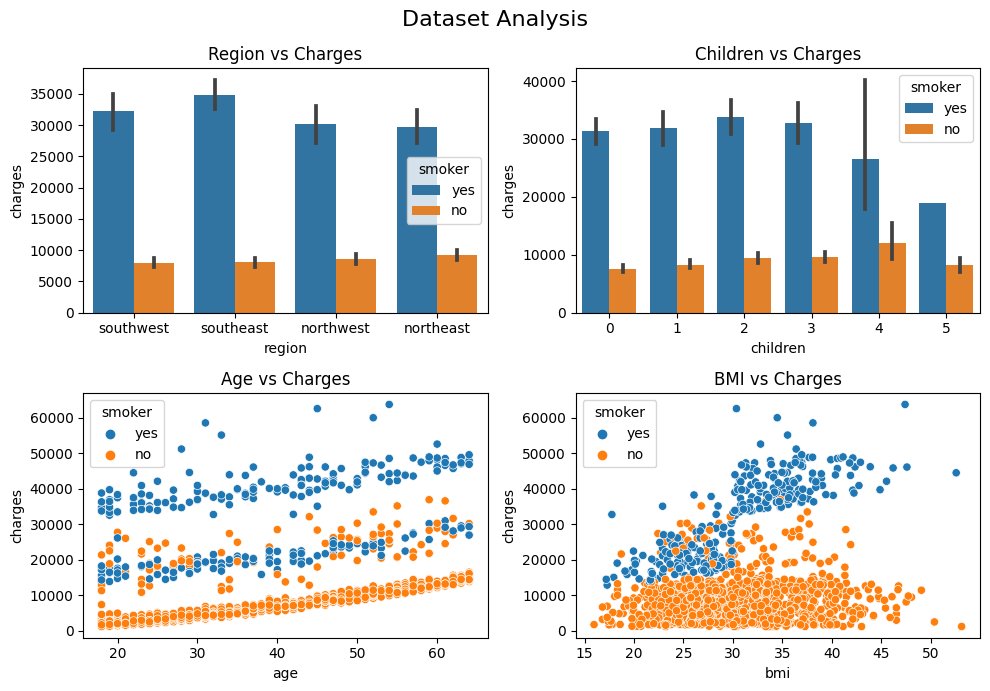



📊 The following plot will help visualize the distribution of the dataset after it has been split into training, cross-validation, and test sets. 
It aids in understanding how the data is distributed across these splits.


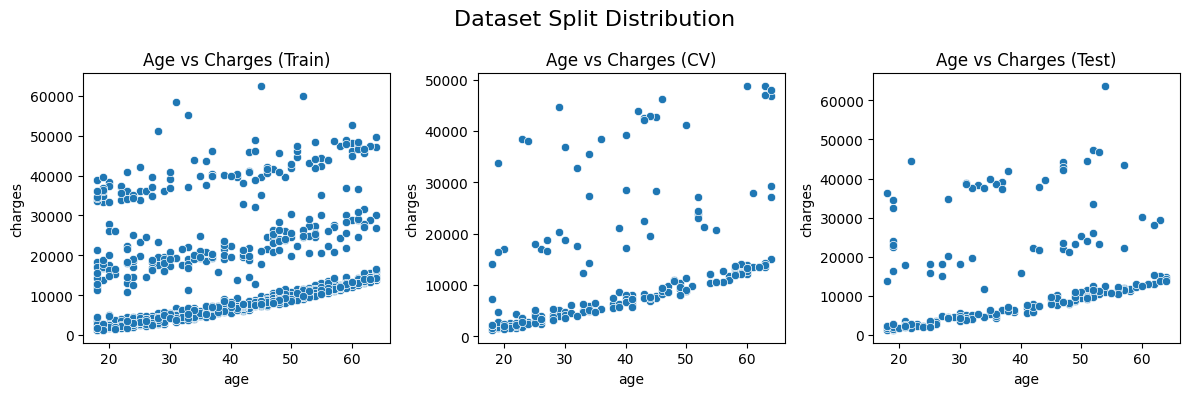

 __  __         _          __  __                     
|  \/  |  __ _ (_) _ __   |  \/  |  ___  _ __   _   _ 
| |\/| | / _` || || '_ \  | |\/| | / _ \| '_ \ | | | |
| |  | || (_| || || | | | | |  | ||  __/| | | || |_| |
|_|  |_| \__,_||_||_| |_| |_|  |_| \___||_| |_| \__,_|
                                                      

1. Analyze Raw Data
2. Show the Models' Training Results
3. Predict the Cost of Insurance
0. Exit

Enter your choice: 2


 _____               _         _                 ____                     _  _        
|_   _| _ __   __ _ (_) _ __  (_) _ __    __ _  |  _ \   ___  ___  _   _ | || |_  ___ 
  | |  | '__| / _` || || '_ \ | || '_ \  / _` | | |_) | / _ \/ __|| | | || || __|/ __|
  | |  | |   | (_| || || | | || || | | || (_| | |  _ < |  __/\__ \| |_| || || |_ \__ \
  |_|  |_|    \__,_||_||_| |_||_||_| |_| \__, | |_| \_\ \___||___/ \__,_||_| \__||___/
                                         |___/                                        

Linear Model Score (CV):

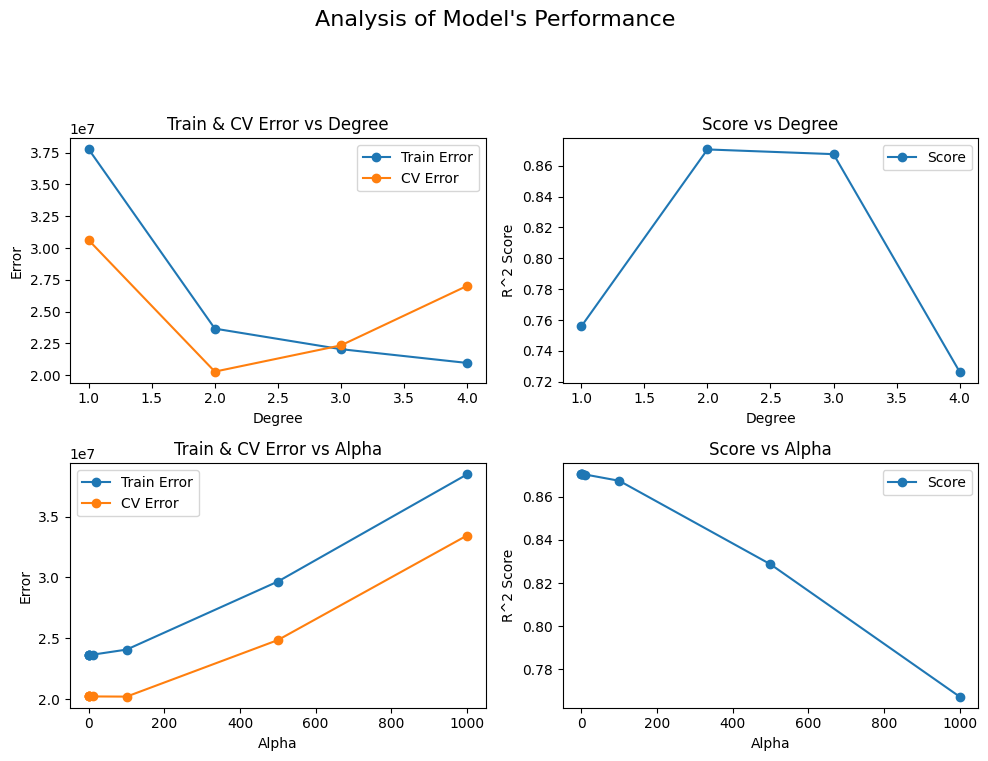



Press ENTER to continue...


7/7 [==============================] - 0s 3ms/step
Neural Network Model Score (CV): 86.74%
Neural Network Model Score (Test Set): 87.34%

📊 The following plot represents the performance metrics of Neural Network during training.



Press ENTER to continue...


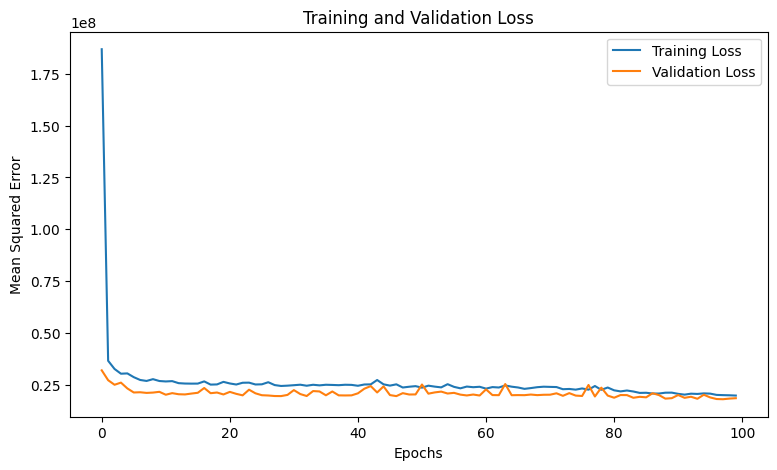



Press ENTER to continue...


Random Forest Model Score (CV): 86.23%
Random Forest Score (Test Set): 86.76%

📊 The following plot represents how much each feature influences the cost of insurance.



Press ENTER to continue...


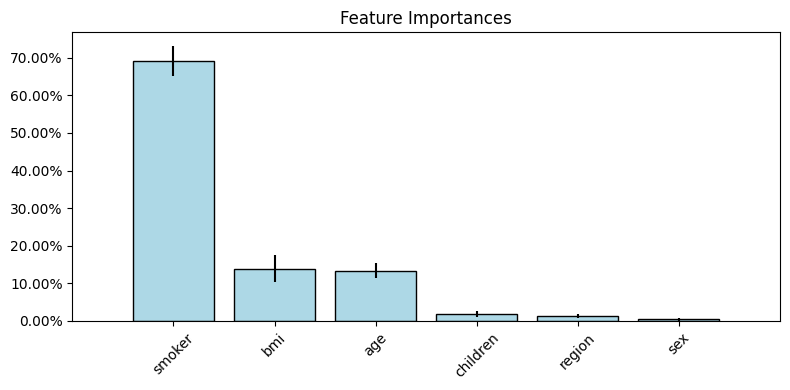



Press ENTER to continue...
 __  __         _          __  __                     
|  \/  |  __ _ (_) _ __   |  \/  |  ___  _ __   _   _ 
| |\/| | / _` || || '_ \  | |\/| | / _ \| '_ \ | | | |
| |  | || (_| || || | | | | |  | ||  __/| | | || |_| |
|_|  |_| \__,_||_||_| |_| |_|  |_| \___||_| |_| \__,_|
                                                      

1. Analyze Raw Data
2. Show the Models' Training Results
3. Predict the Cost of Insurance
0. Exit

Enter your choice: 3


 ____                   _  _        _    _                 __  __                     
|  _ \  _ __   ___   __| |(_)  ___ | |_ (_)  ___   _ __   |  \/  |  ___  _ __   _   _ 
| |_) || '__| / _ \ / _` || | / __|| __|| | / _ \ | '_ \  | |\/| | / _ \| '_ \ | | | |
|  __/ | |   |  __/| (_| || || (__ | |_ | || (_) || | | | | |  | ||  __/| | | || |_| |
|_|    |_|    \___| \__,_||_| \___| \__||_| \___/ |_| |_| |_|  |_| \___||_| |_| \__,_|
                                                                                   

In [ ]:


# =========================================================================
#                      Program's Starting Point
# =========================================================================



tprint("Hello")

print(
    f"{GREEN}{BOLD}👋 Welcome to the Intelligent Premium Estimator!{END}\n\n"
    f"In the upcoming steps, we'll be training four different machine learning models to predict insurance costs:\n"
    f"\t{BOLD}1. Linear Regression Model{END}\n"
    f"\t{BOLD}2. Polynomial Regression Model{END}\n"
    f"\t{BOLD}3. Neural Network Model{END}\n"
    f"\t{BOLD}4. Random Forest Regression Model{END}\n\n"
    f"Our goal is to evaluate the performance of each model and determine which one provides the most accurate predictions.\n"
    f"After training, you'll be able to view detailed results and even predict insurance costs based on custom inputs.\n\n"
    f"{BOLD}Let's dive in!{END}"
)



choice = input(str_pressEnter)
print("Please wait while we train our models...\n\n")

# train our models
model_linear = LinearModel(filepath)
model_poly = PolynomialRegressionModel(filepath)
model_nn = NeuralNetworkModel(filepath)
model_forest = RandomForestModel(filepath)


main_menu()